<a href="https://colab.research.google.com/github/MuhammadDanyialKhan/Google-Colaboratory-Notebooks/blob/master/exercise_flowers_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

W0807 17:13:06.620012 140013759133568 __init__.py:687] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Download the Flowers Dataset using TensorFlow Datasets

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))

splits, dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True, split = splits)

(training_set, validation_set) = splits

num_training_examples = dataset_info.splits['train'].num_examples
num_classes = dataset_info.features['label'].num_classes


# Print Information about the Flowers Dataset

In [66]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2950
Total Number of Validation Images: 720 



The images in the Flowers dataset are not all the same size.



In [11]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 1
Image 2 shape: (332, 500, 3) label: 3
Image 3 shape: (331, 500, 3) label: 3
Image 4 shape: (332, 500, 3) label: 1
Image 5 shape: (333, 500, 3) label: 2


# Reformat Images and Create Batches

In [0]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/225.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Do Simple Transfer Learning with TensorFlow Hub

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

## Freeze the Pre-Trained Model

In [0]:
feature_extractor.trainable = False

### Attach a classification head

In [15]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the model

In [16]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
93/93 [==============================] - 19s 210ms/step - loss: 0.9825 - acc: 0.6647 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
93/93 [==============================] - 9s 98ms/step - loss: 0.5652 - acc: 0.8400 - val_loss: 0.4933 - val_acc: 0.8528
Epoch 3/6
93/93 [==============================] - 9s 97ms/step - loss: 0.4639 - acc: 0.8793 - val_loss: 0.4626 - val_acc: 0.8667
Epoch 4/6
93/93 [==============================] - 9s 98ms/step - loss: 0.4068 - acc: 0.8993 - val_loss: 0.4499 - val_acc: 0.8694
Epoch 5/6
93/93 [==============================] - 9s 99ms/step - loss: 0.3674 - acc: 0.9159 - val_loss: 0.4428 - val_acc: 0.8708
Epoch 6/6
93/93 [==============================] - 9s 98ms/step - loss: 0.3374 - acc: 0.9271 - val_loss: 0.4387 - val_acc: 0.8681


#  Plot Training and Validation Graphs

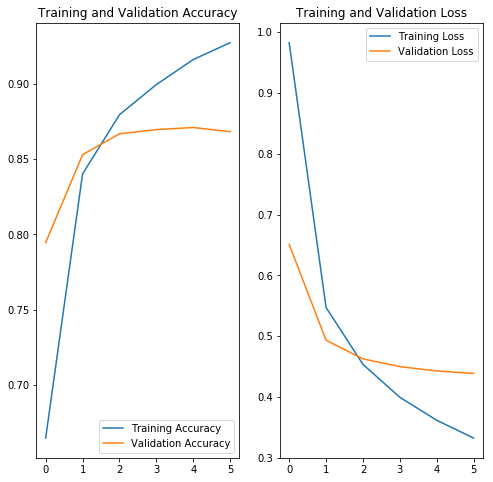

In [38]:
def plot_trainning_and_validation_graph(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    


  
plot_trainning_and_validation_graph(history)
plt.show()

## Check Predictions

In [19]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

### Create an Image Batch and Make Predictions

In [61]:
image_batch, label_batch = next(iter(validation_batches.take(2)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

def make_predictions(model, img_batch):
    predicted_batch = model.predict(img_batch)
    predicted_batch = tf.squeeze(predicted_batch).numpy()
    predicted_ids = np.argmax(predicted_batch, axis=-1)
    predicted_class_names = class_names[predicted_ids]
    print(predicted_class_names)
    return predicted_ids
    
    
predicted_ids = make_predictions(model, image_batch)

['sunflowers' 'daisy' 'daisy' 'sunflowers' 'dandelion' 'sunflowers'
 'dandelion' 'tulips' 'daisy' 'dandelion' 'dandelion' 'dandelion' 'roses'
 'dandelion' 'dandelion' 'tulips' 'tulips' 'roses' 'dandelion'
 'sunflowers' 'dandelion' 'tulips' 'dandelion' 'daisy' 'daisy' 'dandelion'
 'sunflowers' 'dandelion' 'tulips' 'roses' 'roses' 'tulips']


### Print True Labels and Predicted Indices

In [62]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [3 1 1 3 0 3 0 2 4 0 0 0 4 0 0 2 2 4 0 3 0 2 0 1 1 0 3 0 2 4 4 2]
Predicted labels:  [3 1 1 3 0 3 0 2 1 0 0 0 4 0 0 2 2 4 0 3 0 2 0 1 1 0 3 0 2 4 4 2]


# Plot Model Predictions

In [0]:
def plot_model_predictions(predicted_id, labels):
    plt.figure(figsize=(10,9))
    for n in range(30):
      plt.subplot(6,5,n+1)
      plt.subplots_adjust(hspace = 0.3)
      plt.imshow(image_batch[n])
      color = "blue" if predicted_id[n] == labels[n] else "red"
      plt.title(predicted_class_names[n].title(), color=color)
      plt.axis('off')
    _ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

W0807 18:45:54.316853 140013759133568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 18:45:54.330358 140013759133568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 18:45:54.342492 140013759133568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 18:45:54.354820 140013759133568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 18:45:54.367608 140013759133568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 18:45:54.380420 140013759133568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 18:45:54.393035 140013

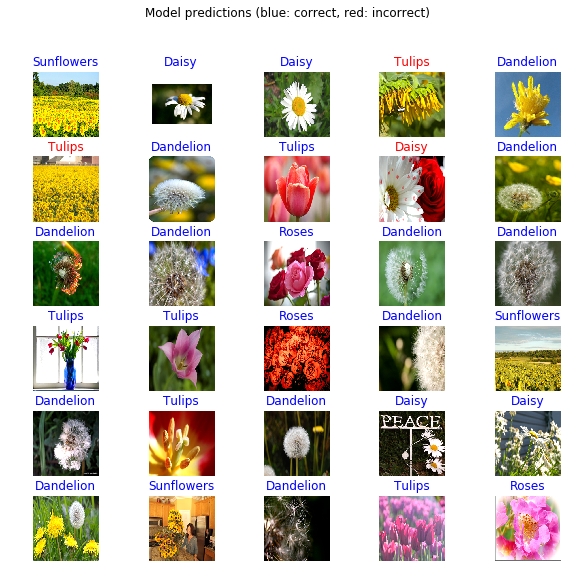

In [59]:
plot_model_predictions(predicted_ids, label_batch)

# Perform Transfer Learning with the Inception Model

https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4

In [0]:
IMAGE_RES = 299

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [0]:
feature_extractor.trainable = False

In [48]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [49]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
93/93 [==============================] - 34s 365ms/step - loss: 1.2070 - acc: 0.6525 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
93/93 [==============================] - 17s 183ms/step - loss: 0.7742 - acc: 0.8302 - val_loss: 0.6889 - val_acc: 0.8556
Epoch 3/6
93/93 [==============================] - 17s 187ms/step - loss: 0.6607 - acc: 0.8658 - val_loss: 0.6412 - val_acc: 0.8708
Epoch 4/6
93/93 [==============================] - 17s 186ms/step - loss: 0.5992 - acc: 0.8902 - val_loss: 0.6170 - val_acc: 0.8736
Epoch 5/6
93/93 [==============================] - 17s 183ms/step - loss: 0.5575 - acc: 0.9034 - val_loss: 0.6011 - val_acc: 0.8792
Epoch 6/6
93/93 [==============================] - 17s 183ms/step - loss: 0.5259 - acc: 0.9125 - val_loss: 0.5900 - val_acc: 0.8806


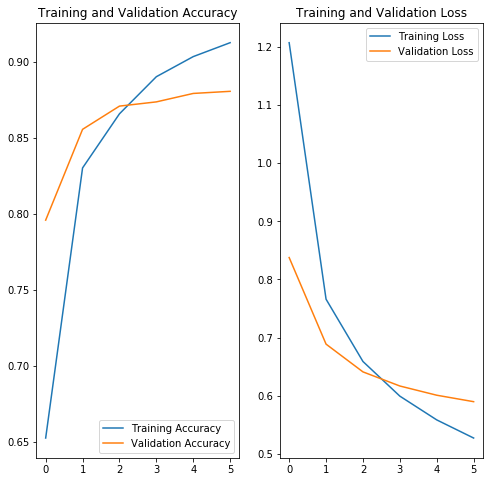

In [50]:
plot_trainning_and_validation_graph(history)
plt.show()

In [64]:
image_batch, label_batch = next(iter(validation_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_ids = make_predictions(model, image_batch)
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

['sunflowers' 'daisy' 'daisy' 'sunflowers' 'dandelion' 'sunflowers'
 'dandelion' 'tulips' 'daisy' 'dandelion' 'dandelion' 'dandelion' 'roses'
 'dandelion' 'dandelion' 'tulips' 'tulips' 'roses' 'dandelion'
 'sunflowers' 'dandelion' 'tulips' 'dandelion' 'daisy' 'daisy' 'dandelion'
 'sunflowers' 'dandelion' 'tulips' 'roses' 'roses' 'tulips']
Labels:  [3 1 1 3 0 3 0 2 4 0 0 0 4 0 0 2 2 4 0 3 0 2 0 1 1 0 3 0 2 4 4 2]
Predicted labels:  [3 1 1 3 0 3 0 2 1 0 0 0 4 0 0 2 2 4 0 3 0 2 0 1 1 0 3 0 2 4 4 2]


W0807 18:50:08.745381 140013759133568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 18:50:08.759425 140013759133568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 18:50:08.775396 140013759133568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 18:50:08.789755 140013759133568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 18:50:08.804061 140013759133568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 18:50:08.817740 140013759133568 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0807 18:50:08.832951 140013

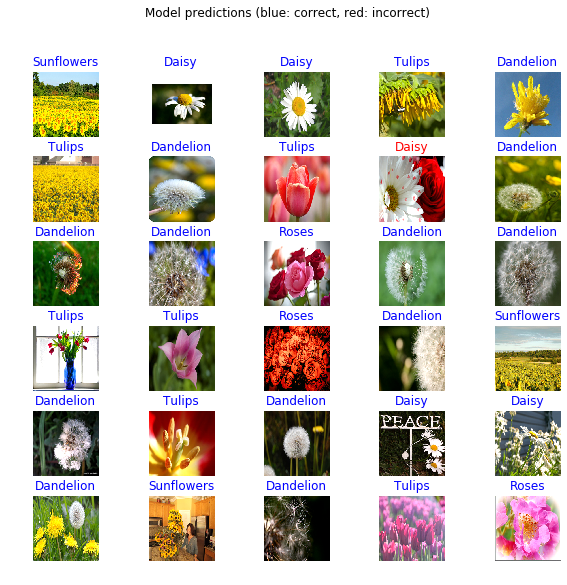

In [65]:
plot_model_predictions(predicted_ids, label_batch)